In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import zipfile
import os

gopro_zip_path = '/content/drive/MyDrive/GoPro.zip'  # Update if path is different
gopro_extract_path = '/content/gopro_dataset/'

# Unzipping GoPro
with zipfile.ZipFile(gopro_zip_path, 'r') as zip_ref:
    zip_ref.extractall(gopro_extract_path)

print(" GoPro dataset unzipped to:", gopro_extract_path)


 GoPro dataset unzipped to: /content/gopro_dataset/


In [3]:
import os
import shutil
import random

def split_train_val(data_dir, val_ratio=0.1, seed=42):
    blur_dir = os.path.join(data_dir, 'train', 'blur')
    gt_dir = os.path.join(data_dir, 'train', 'GT')
    val_blur_dir = os.path.join(data_dir, 'val', 'blur')
    val_gt_dir = os.path.join(data_dir, 'val', 'GT')

    os.makedirs(val_blur_dir, exist_ok=True)
    os.makedirs(val_gt_dir, exist_ok=True)

    scenes = sorted(os.listdir(blur_dir))
    random.seed(seed)
    val_scenes = random.sample(scenes, int(len(scenes) * val_ratio))

    for scene in val_scenes:
        shutil.move(os.path.join(blur_dir, scene), os.path.join(val_blur_dir, scene))
        shutil.move(os.path.join(gt_dir, scene), os.path.join(val_gt_dir, scene))

    print(f"Moved {len(val_scenes)} scenes to validation set.")

# Example usage
split_train_val('/content/gopro_dataset/GoPro', val_ratio=0.1)


Moved 2 scenes to validation set.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleTemporalUNet(nn.Module):
    def __init__(self, in_channels=9, out_channels=3, base_filters=32):
        super(SimpleTemporalUNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        # Encoder path
        self.enc1 = conv_block(in_channels, base_filters)       # 9 -> 32
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(base_filters, base_filters*2)    # 32 -> 64
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = conv_block(base_filters*2, base_filters*4)  # 64 -> 128
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = conv_block(base_filters*4, base_filters*8)  # 128 -> 256

        # Bottleneck
        self.bottleneck = conv_block(base_filters*8, base_filters*16)  # 256 -> 512

        # Decoder path
        self.up4 = nn.ConvTranspose2d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.dec4 = conv_block(base_filters*16, base_filters*8)

        self.up3 = nn.ConvTranspose2d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.dec3 = conv_block(base_filters*8, base_filters*4)

        self.up2 = nn.ConvTranspose2d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.dec2 = conv_block(base_filters*4, base_filters*2)

        self.up1 = nn.ConvTranspose2d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.dec1 = conv_block(base_filters*2, base_filters)

        # Final conv (to RGB output)
        self.final_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)        # [B, 32, H, W]
        p1 = self.pool1(e1)      # Downsample

        e2 = self.enc2(p1)       # [B, 64, H/2, W/2]
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)       # [B, 128, H/4, W/4]
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)       # [B, 256, H/8, W/8]

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))  # [B, 512, H/16, W/16]

        # Decoder
        d4 = self.up4(b)                               # Upsample
        d4 = torch.cat([d4, e4], dim=1)               # Skip connection
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        out = torch.sigmoid(out)  # Normalize output to [0,1]

        return out

In [5]:
import os
import glob
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

class VideoTripletDataset(Dataset):
    def __init__(self, blur_dir, gt_dir):
        self.blur_dir = blur_dir
        self.gt_dir = gt_dir
        self.samples = []
        self.transform = transforms.ToTensor()

        for scene in sorted(os.listdir(blur_dir)):
            blur_scene_path = os.path.join(blur_dir, scene)
            gt_scene_path = os.path.join(gt_dir, scene)

            if not os.path.isdir(blur_scene_path) or not os.path.isdir(gt_scene_path):
                continue

            blur_images = sorted(glob.glob(os.path.join(blur_scene_path, "*.png")))

            for i in range(1, len(blur_images) - 1):
                center_name = os.path.basename(blur_images[i])
                gt_path = os.path.join(gt_scene_path, center_name)

                if os.path.exists(gt_path):
                    triplet = [blur_images[i-1], blur_images[i], blur_images[i+1]]
                    self.samples.append((triplet, gt_path))

    def __len__(self):
        return len(self.samples)

    def _read_rgb_image(self, path):
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise IOError(f"Failed to load image: {path}")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def __getitem__(self, idx):
        blur_paths, gt_path = self.samples[idx]

        # Read triplet + GT
        blurs = [self._read_rgb_image(p) for p in blur_paths]
        gt = self._read_rgb_image(gt_path)

        # Minimal consistent center crop to align sizes
        h = min([img.shape[0] for img in blurs] + [gt.shape[0]])
        w = min([img.shape[1] for img in blurs] + [gt.shape[1]])
        h -= h % 16  # Optional: ensure divisible by 16 for UNet
        w -= w % 16

        def crop_center(img, h, w):
            ch, cw = img.shape[:2]
            start_y = (ch - h) // 2
            start_x = (cw - w) // 2
            return img[start_y:start_y+h, start_x:start_x+w]

        blurs = [crop_center(img, h, w) for img in blurs]
        gt = crop_center(gt, h, w)

        # Stack 3 frames into 9-channel input
        blur_tensor = torch.cat([self.transform(img) for img in blurs], dim=0)  # Shape: [9, H, W]
        gt_tensor = self.transform(gt)  # Shape: [3, H, W]

        return blur_tensor.float(), gt_tensor.float()


In [6]:
val_blur = '/content/gopro_dataset/GoPro/val/blur'
val_gt = '/content/gopro_dataset/GoPro/val/GT'

In [7]:
val_dataset = VideoTripletDataset(val_blur, val_gt)  # Replace with your dataset initialization


In [8]:
model = SimpleTemporalUNet()  # or however you initialize your model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.load_state_dict(torch.load('/content/drive/MyDrive/model_checkpoints/best_model.pth', map_location=device))
model.to(device)
model.eval()


SimpleTemporalUNet(
  (enc1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

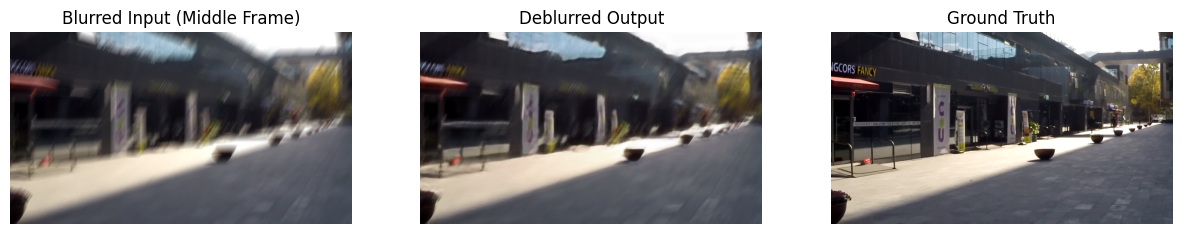

In [18]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def visualize_deblur(model, val_dataset, device='cuda'):
    input_tensor, target_tensor = val_dataset[101]  # (C=9, H, W) or (C=9, T=3, H, W) depending on your data

    # If input tensor shape is (9, H, W), split into 3 frames (3, H, W)
    # Extract middle frame (channels 3:6)
    input_frame = input_tensor[3:6, :, :]  # middle frame RGB

    # Model expects full input (all 9 channels), so prepare batch accordingly
    input_batch = input_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_batch)

    # Output is probably 3 channels (deblurred RGB)
    output_img = output.squeeze(0).cpu().clamp(0,1)
    target_img = target_tensor.cpu().clamp(0,1)

    # Convert to PIL images
    input_img = to_pil_image(input_frame)
    output_img = to_pil_image(output_img)
    target_img = to_pil_image(target_img)

    # Plot images
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs[0].imshow(input_img)
    axs[0].set_title("Blurred Input (Middle Frame)")
    axs[0].axis('off')

    axs[1].imshow(output_img)
    axs[1].set_title("Deblurred Output")
    axs[1].axis('off')

    axs[2].imshow(target_img)
    axs[2].set_title("Ground Truth")
    axs[2].axis('off')

    plt.show()

# Call the function
visualize_deblur(model, val_dataset, device)
